In [92]:
import pandas as pd
import sqlite3
import pathlib
from sqlalchemy import  create_engine
import numpy as np
import matplotlib.pyplot as plt
import json
import os
import pathlib
from dr_analysis_tools import get_exp_paths
import math

In [93]:
if __name__ == '__main__':
    # ------------------------------------------------------------------------------------
    # allow integers >8 bytes to be stored in sqlite3
    sqlite3.register_adapter(np.int64, lambda val: int(val))
    sqlite3.register_adapter(np.int32, lambda val: int(val))
    # ------------------------------------------------------------------------------------
    DB_PATH = pathlib.Path('//allen/programs/mindscope/workgroups/dynamicrouting/dynamic_gating_insertions/dr_master.db')
    # with contextlib.suppress(OSError):
    #     DB_PATH.unlink()
    sqlite3.connect(DB_PATH).close()
    DB = f"sqlite:///{DB_PATH}"
    ENGINE = create_engine(DB, echo=False)

In [94]:
table_name = 'channel_ccf_coords'
df_sessions = pd.read_sql_table(table_name, con=ENGINE)

In [95]:
probes = ['A', 'B', 'C', 'D', 'E', 'F']

In [96]:
##only works if mouse has probe_insertions jsons
def insertion_holes_from_json(mouse):
    paths = get_exp_paths(mouse)
    json_list = []
    for path in paths:
        p_list = os.listdir(path)
        for p in p_list:
            if 'probe_insertions' in p:
                json_list.append(os.path.join(path, p))
    
    insertions = {}
    for j in json_list:
        with open(j) as file:
            data = json.load(file)
        for probe in probes:
            hole = data['probe_insertions']['probe' + probe]['hole']
            insertions[probe + str(data['probe_insertions']['day_1-4'])] = hole
    return insertions

In [97]:
##only works if mouse is in channel_ccf_coords table
def insertion_holes_from_db(mouse):
    mouse_df = df_sessions[df_sessions['MID'] == mouse]
    insertions = {}
    for index, row in mouse_df.iterrows():
        insertions[row['Probe'] + str(row['Day'])] = row['Hole']
    return insertions

In [98]:
##in bregma (anything in mm will do)
hole_coords_2002 = {
    'A1': [-.75, -.3],
    'A2': [-.95, 2.05],
    'A3': [-1.25, 2.5], #guess
    'B1': [-.92, -1.19],
    'B2': [-.96, -3.1],
    'B3': [-.75, .9],
    'B4': [-1.5, .325],
    'C1': [-1.53, -3.95],
    'C2': [-1.59, -2.39],
    'C3': [-2.3, -1.9],
    'C4': [-.7, -2.05],
    'D1': [-3.85, -3.7],
    'D2': [-3.08, -3.55],
    'D3': [-2.2, -3.2],
    'E1': [-3.44, -.98],
    'E2': [-3.56, -2.83],
    'E3': [-3.25, 0.0],
    'E4': [-3.6, -1.9],
    'F1': [-2.6, 1.8],
    'F2': [-1.74, 2.1],
    'F3': [-2.8, .9],
    None : [np.nan, np.nan], 
}

In [99]:
##returns 'probeDay - probeDay' : [x, y] for each probe's implant hole across days
def get_implant_vectors(insertions):
    implant_coords = {}
    implant_vectors = {} 
    for k, v in insertions.items():
        #for multiple implants, 
        #hole_dict = 'hole_coords_' + implant
        #implant_coords[k] = np.array(hole_dict[insertions[k]])
        implant_coords[k] = np.array(hole_coords_2002[insertions[k]])

    for probe in probes:
        probedict = {}
        for k, v in implant_coords.items():
            if probe in k:
                probedict[k] = v
            for i in range(len(probedict)):
                for k,v in probedict.items():
                    implant_vectors[probe + str(i+1) + '-' + k] = v - probedict[probe + str(i+1)]
    return implant_vectors

In [100]:
##returns 'probeDay' : [ML, -AP] coords in mm for each inserted probe
##change to take dorsal-most annotation point or point from reassignment line
def get_surface_ccf_coords(mouse):
    surface_channels = {}
    mouse_df = df_sessions[df_sessions['MID'] == mouse]
    implant = mouse_df.iloc[0]['Implant']
    if implant != '2002':
        print('Caution! no hole coordinates for implant ' + implant)
    for i in range(len(mouse_df)):
        arr0 = mouse_df.iloc[i].to_numpy()
        key = str(arr0[4]) + str(arr0[3])
        if arr0[8] != 'No annotation file':
            channels = arr0[9:]
            arr1 = channels.reshape((384, 4))
            coords = arr1[(arr1[:, 3] != 'out of brain') & (arr1[:, 3] != 'root')][-1]
            surface_channels[key] = (coords, arr0[8])
        else:
            surface_channels[key] = ([-1, -1, -1], arr0[8])

    coords = {}
    for k, v in surface_channels.items():
        coords[k] = (np.array([(v[0][2]/40), -(v[0][0]/40)]), v[1])
    
    return coords

In [101]:
##returns 'probeDay - probeDay' : [x, y] vectors for each probe's annotation across days
def get_annotation_vectors(coords):
    ann_vectors = {}
    for probe in probes:
        probedict = {}
        for k, v in coords.items():
            if probe in k:
                probedict[k] = v
        for i in range(4):
            for k,v in probedict.items():
                if probe + str(i+1) in probedict:
                    ann_vectors[probe + str(i+1) + '-' + k] = (v[0] - probedict[probe + str(i+1)][0], v[1])
                else:
                    ann_vectors[probe + str(i+1) + '-' + k] = (np.array([-1, -1]), v[1])
    return ann_vectors

In [102]:
coords = get_surface_ccf_coords(636766)
ann_vectors = get_annotation_vectors(coords)
ann_vectors.keys()

dict_keys(['A1-A1', 'A1-A2', 'A1-A3', 'A1-A4', 'A2-A1', 'A2-A2', 'A2-A3', 'A2-A4', 'A3-A1', 'A3-A2', 'A3-A3', 'A3-A4', 'A4-A1', 'A4-A2', 'A4-A3', 'A4-A4', 'B1-B1', 'B1-B2', 'B1-B3', 'B1-B4', 'B2-B1', 'B2-B2', 'B2-B3', 'B2-B4', 'B3-B1', 'B3-B2', 'B3-B3', 'B3-B4', 'B4-B1', 'B4-B2', 'B4-B3', 'B4-B4', 'C1-C1', 'C1-C2', 'C1-C3', 'C1-C4', 'C2-C1', 'C2-C2', 'C2-C3', 'C2-C4', 'C3-C1', 'C3-C2', 'C3-C3', 'C3-C4', 'C4-C1', 'C4-C2', 'C4-C3', 'C4-C4', 'D1-D1', 'D1-D2', 'D1-D3', 'D1-D4', 'D2-D1', 'D2-D2', 'D2-D3', 'D2-D4', 'D3-D1', 'D3-D2', 'D3-D3', 'D3-D4', 'D4-D1', 'D4-D2', 'D4-D3', 'D4-D4', 'E1-E1', 'E1-E2', 'E1-E3', 'E1-E4', 'E2-E1', 'E2-E2', 'E2-E3', 'E2-E4', 'E3-E1', 'E3-E2', 'E3-E3', 'E3-E4', 'E4-E1', 'E4-E2', 'E4-E3', 'E4-E4', 'F1-F1', 'F1-F2', 'F1-F3', 'F1-F4', 'F2-F1', 'F2-F2', 'F2-F3', 'F2-F4', 'F3-F1', 'F3-F2', 'F3-F3', 'F3-F4', 'F4-F1', 'F4-F2', 'F4-F3', 'F4-F4'])

In [103]:
##plots implant vectors as blue arrow and annotation vectors as red arrow for each probe combo
    #needs a key for the arrows 
    #limitations: only 2002 for now, can't handle missing annotations on days 1-3
def plot_vectors(ann_vectors, implant_vectors):
    for probe in probes:
        probe_ann_vectors = {}
        val_list = []
        for k, v in ann_vectors.items():
            if probe in k:
                probe_ann_vectors[k] = v
                val_list.append(v)
        
        probe_implant_vectors = {}
        for k, v in implant_vectors.items():
            if probe in k:
                probe_implant_vectors[k] = v
        
        if len(probe_ann_vectors) != 0:
            vals = np.array(val_list)
            maxs = np.nanmax(vals, axis=0)
            mins = np.nanmin(vals, axis=0)

        
            fig = plt.figure(figsize=(8,13))
            gs = fig.add_gridspec(ncols = int(math.sqrt(len(probe_ann_vectors))), nrows = int(math.sqrt(len(probe_ann_vectors))))
            #print(int(math.sqrt(len(probe_ann_vectors))))
            for r in range(int(math.sqrt(len(probe_ann_vectors)))):
                for c in range(int(math.sqrt(len(probe_ann_vectors)))):
                    ax = fig.add_subplot(gs[r, c])
                    ax.quiver([0,0],[0,0], 
                            [probe_ann_vectors[probe + str(r+1) + '-' + probe + str(c+1)][0], probe_implant_vectors[probe + str(r+1) + '-' + probe + str(c+1)][0]], 
                            [probe_ann_vectors[probe + str(r+1) + '-' + probe + str(c+1)][1], probe_implant_vectors[probe + str(r+1) + '-' + probe + str(c+1)][1]], 
                            angles='xy', scale_units='xy', scale=1, color=['r', 'b'])
                    ax.set_title(probe + str(r+1) + '-' + probe + str(c+1), fontsize=10)
                    ax.set_xlim(mins[0]-.5, maxs[0]+.5)
                    ax.set_ylim(mins[1]-.5, maxs[1]+.5)
                    if (r+1) + (c+1) != 2:
                        ax.set_xticks([])
                        ax.set_yticks([])
                    fig.tight_layout()


In [104]:
##trying to figure out how to handle missing annotations on days 1-3
def plot_vectors_scratch(ann_vectors, implant_vectors):
    for probe in probes:
        probe_ann_vectors = {}
        val_list = []
        for k, v in ann_vectors.items():
            if probe in k:
                probe_ann_vectors[k] = v
                val_list.append(v[0])
        
        probe_implant_vectors = {}
        for k, v in implant_vectors.items():
            if probe in k:
                probe_implant_vectors[k] = v

        if len(probe_ann_vectors) != 0:
            vals = np.array(val_list)
            maxs = np.nanmax(vals, axis=0)
            mins = np.nanmin(vals, axis=0)

        
            fig = plt.figure(figsize=(8,13))
            gs = fig.add_gridspec(ncols = 4, nrows = 4)
            
            ##always make it a 4x4, add text in box if probe not inserted
            ##make axes square (just use ymax to set?)
            #add fig.suptitle with key
            for r in range(int(math.sqrt(len(probe_ann_vectors)))):
                for c in range(int(math.sqrt(len(probe_ann_vectors)))):
                    for k in probe_ann_vectors.keys():
                        if probe_ann_vectors[k][1] != 'Annotation not present for one or both':
                            check = True
                        else:
                            check = False
                        
                        if check:
                            ax = fig.add_subplot(gs[r, c])
                            ax.quiver([0,0],[0,0], 
                                    [probe_ann_vectors[probe + str(r+1) + '-' + probe + str(c+1)][0][0], probe_implant_vectors[probe + str(r+1) + '-' + probe + str(c+1)][0]], 
                                    [probe_ann_vectors[probe + str(r+1) + '-' + probe + str(c+1)][0][1], probe_implant_vectors[probe + str(r+1) + '-' + probe + str(c+1)][1]], 
                                    angles='xy', scale_units='xy', scale=1, color=['r', 'b'])
                            ax.set_title(probe + str(r+1) + '-' + probe + str(c+1), fontsize=10)
                            ax.set_xlim(mins[0]-.5, maxs[0]+.5)
                            ax.set_ylim(mins[1]-.5, maxs[1]+.5)
                            if (r+1) + (c+1) != 2:
                                ax.set_xticks([])
                                ax.set_yticks([])
                            fig.tight_layout()
                        else:
                            continue


In [114]:
def plot_vectors_arjun(annotation_vectors, implant_vectors, surface_coords):
    values = list(annotation_vectors.values())
    x_vectors = [value[0][0] for value in values]
    y_vectors = [value[0][1] for value in values]

    for probe in probes:
        vector_probes = np.array([vector for vector in list(annotation_vectors.keys()) if probe in vector]).reshape((4, 4))
        
        fig = plt.figure(figsize=(25,25))
        gs = fig.add_gridspec(ncols = 4, nrows = 4)

        for row in range(vector_probes.shape[0]):
            for column in range(vector_probes.shape[1]):
                vector_key = vector_probes[row, column]
                index = vector_key.index('-')
                first_probe = vector_key[0:index]
                second_probe = vector_key[index+1:]

                annotation_file_first_probe = surface_coords[first_probe][1]
                annotation_file_second_probe = surface_coords[second_probe][1]
                ax = fig.add_subplot(gs[row, column])
                ax.set_title(vector_key)
                ax.set_xlim(min(x_vectors) - 2, max(x_vectors) + 2)
                ax.set_ylim(min(y_vectors) - 2, max(y_vectors) + 2)
                if annotation_file_first_probe != 'No annotation file' and annotation_file_second_probe != 'No annotation file':
                     ax.quiver([0, 0], [0, 0], [annotation_vectors[vector_key][0][0], implant_vectors[vector_key][0]],
                               [annotation_vectors[vector_key][0][1], implant_vectors[vector_key][1]],
                               angles='xy', scale_units='xy', scale=1, color=['r', 'b'])
                else:
                    ax.text(-4, 0, 'Annotations not present \n for one or both', size=18)
        
        fig.tight_layout()
                
                     
        

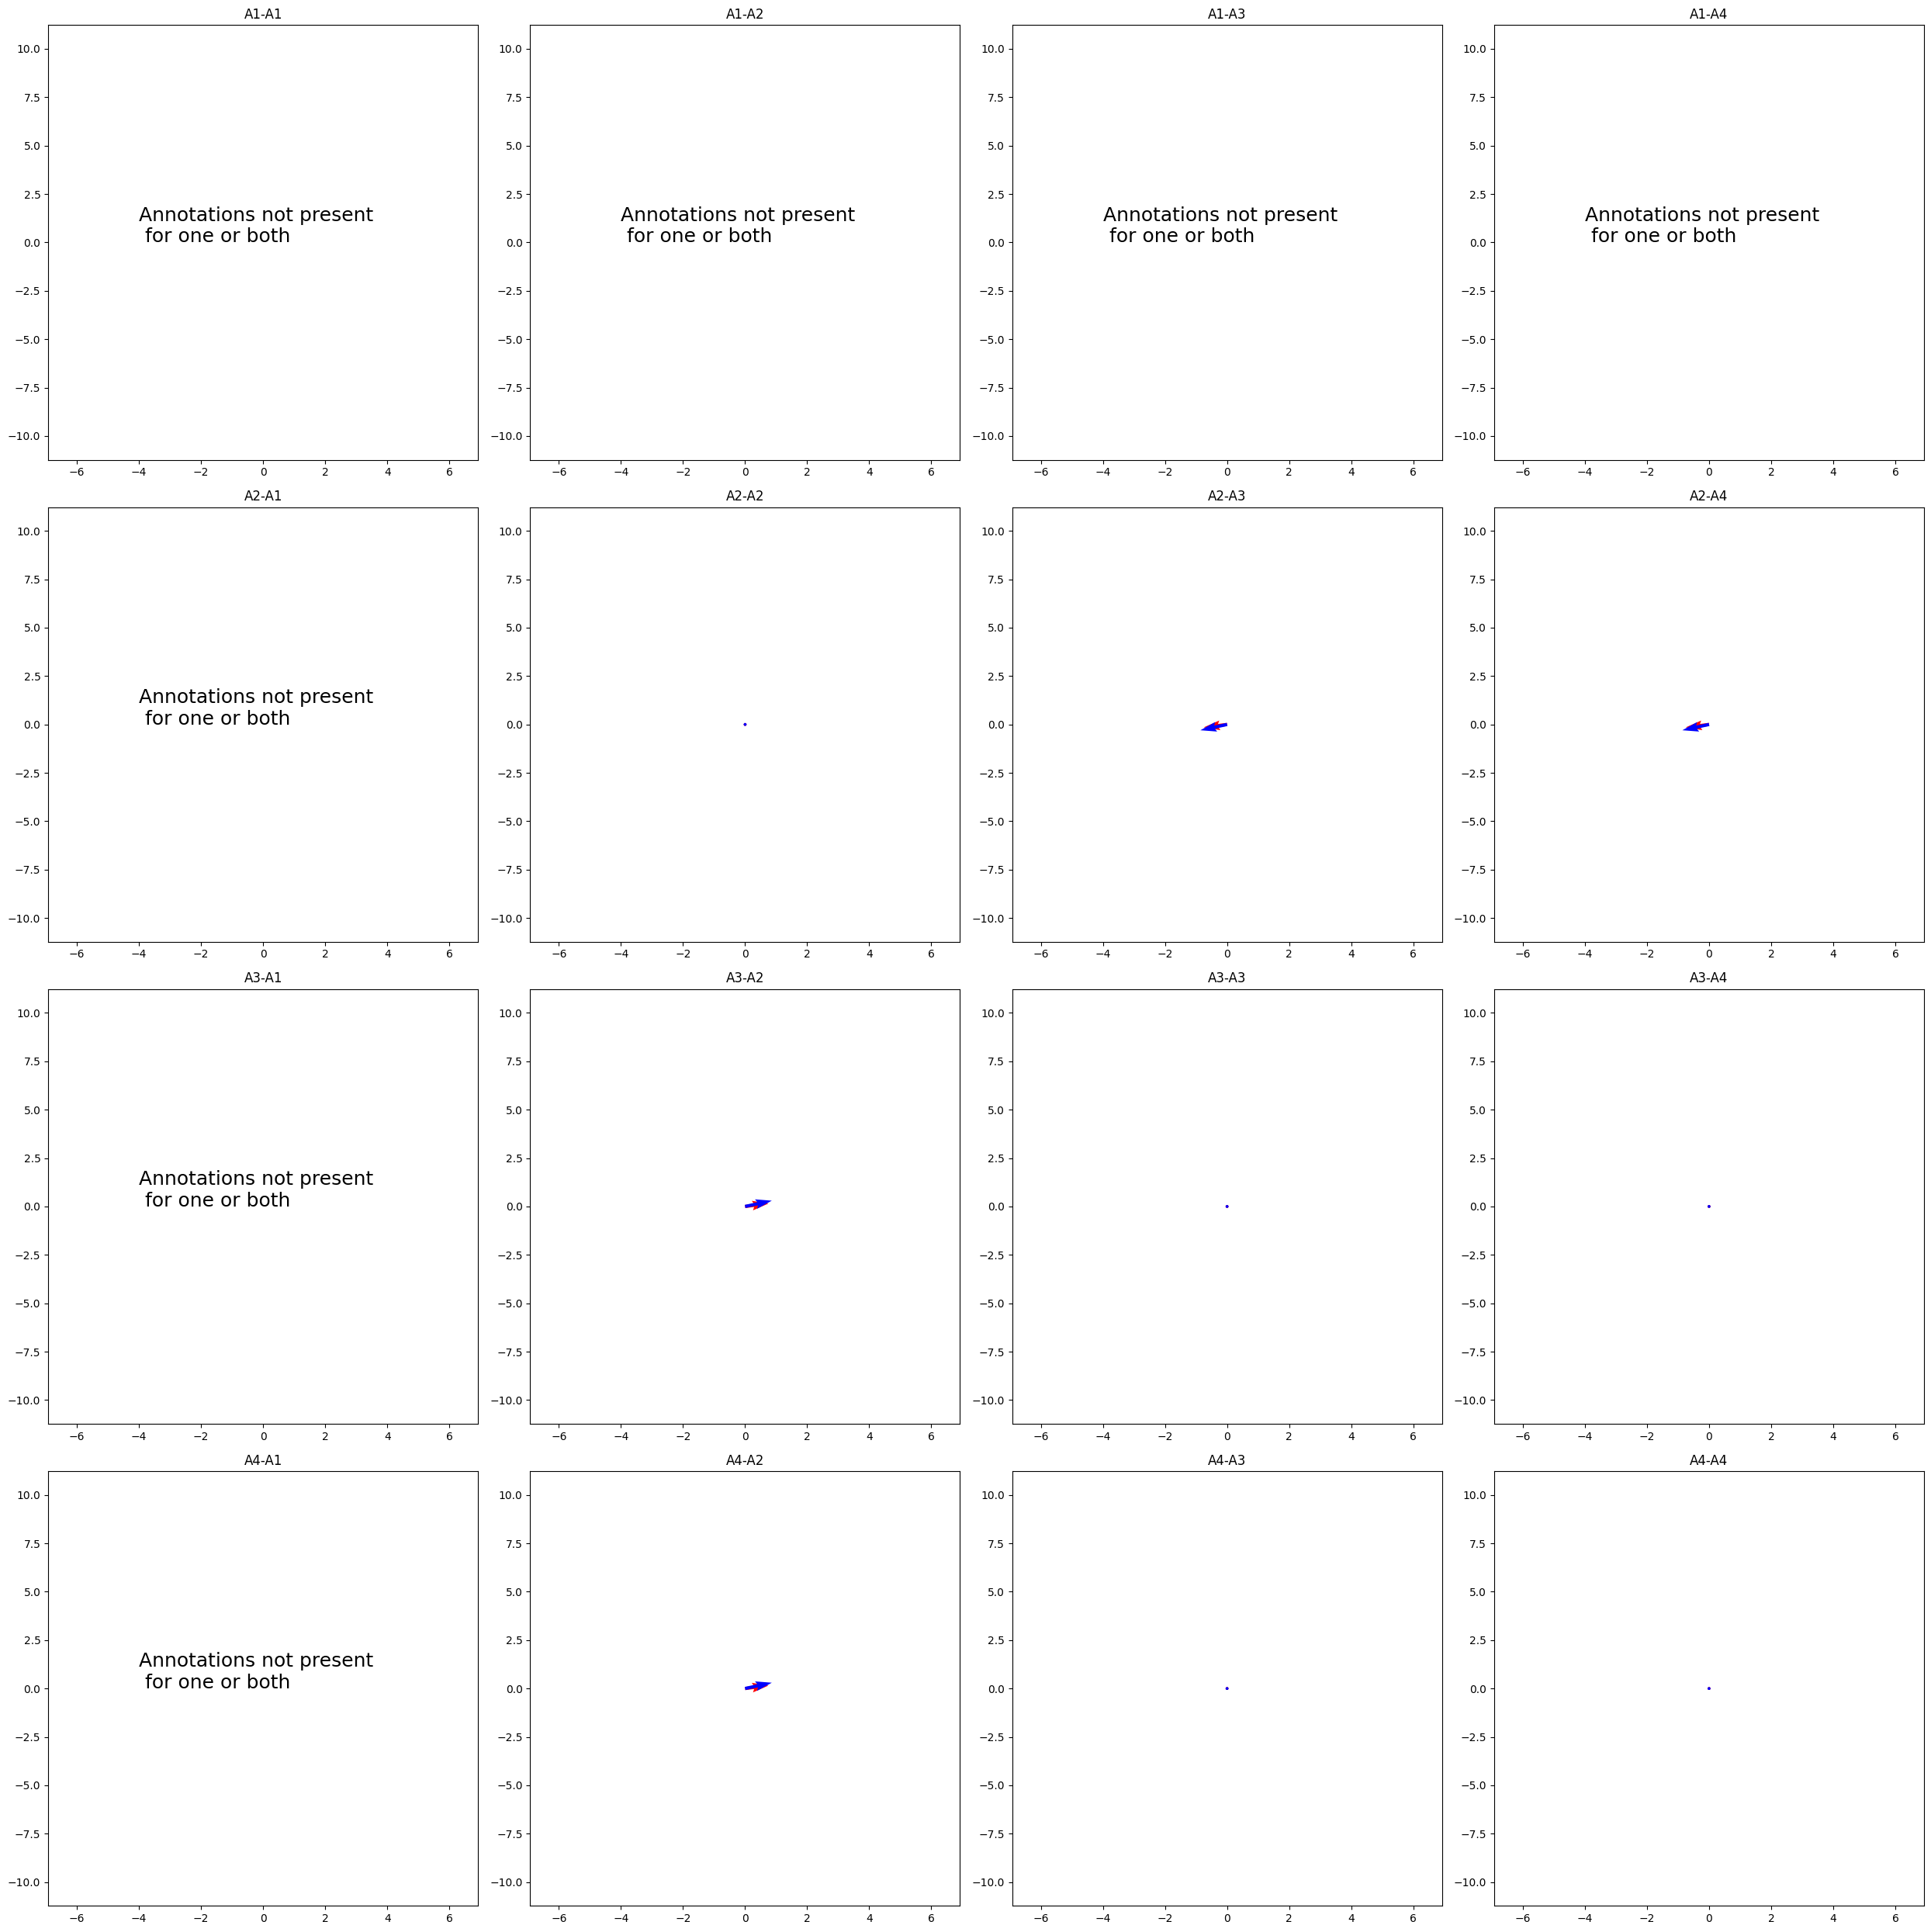

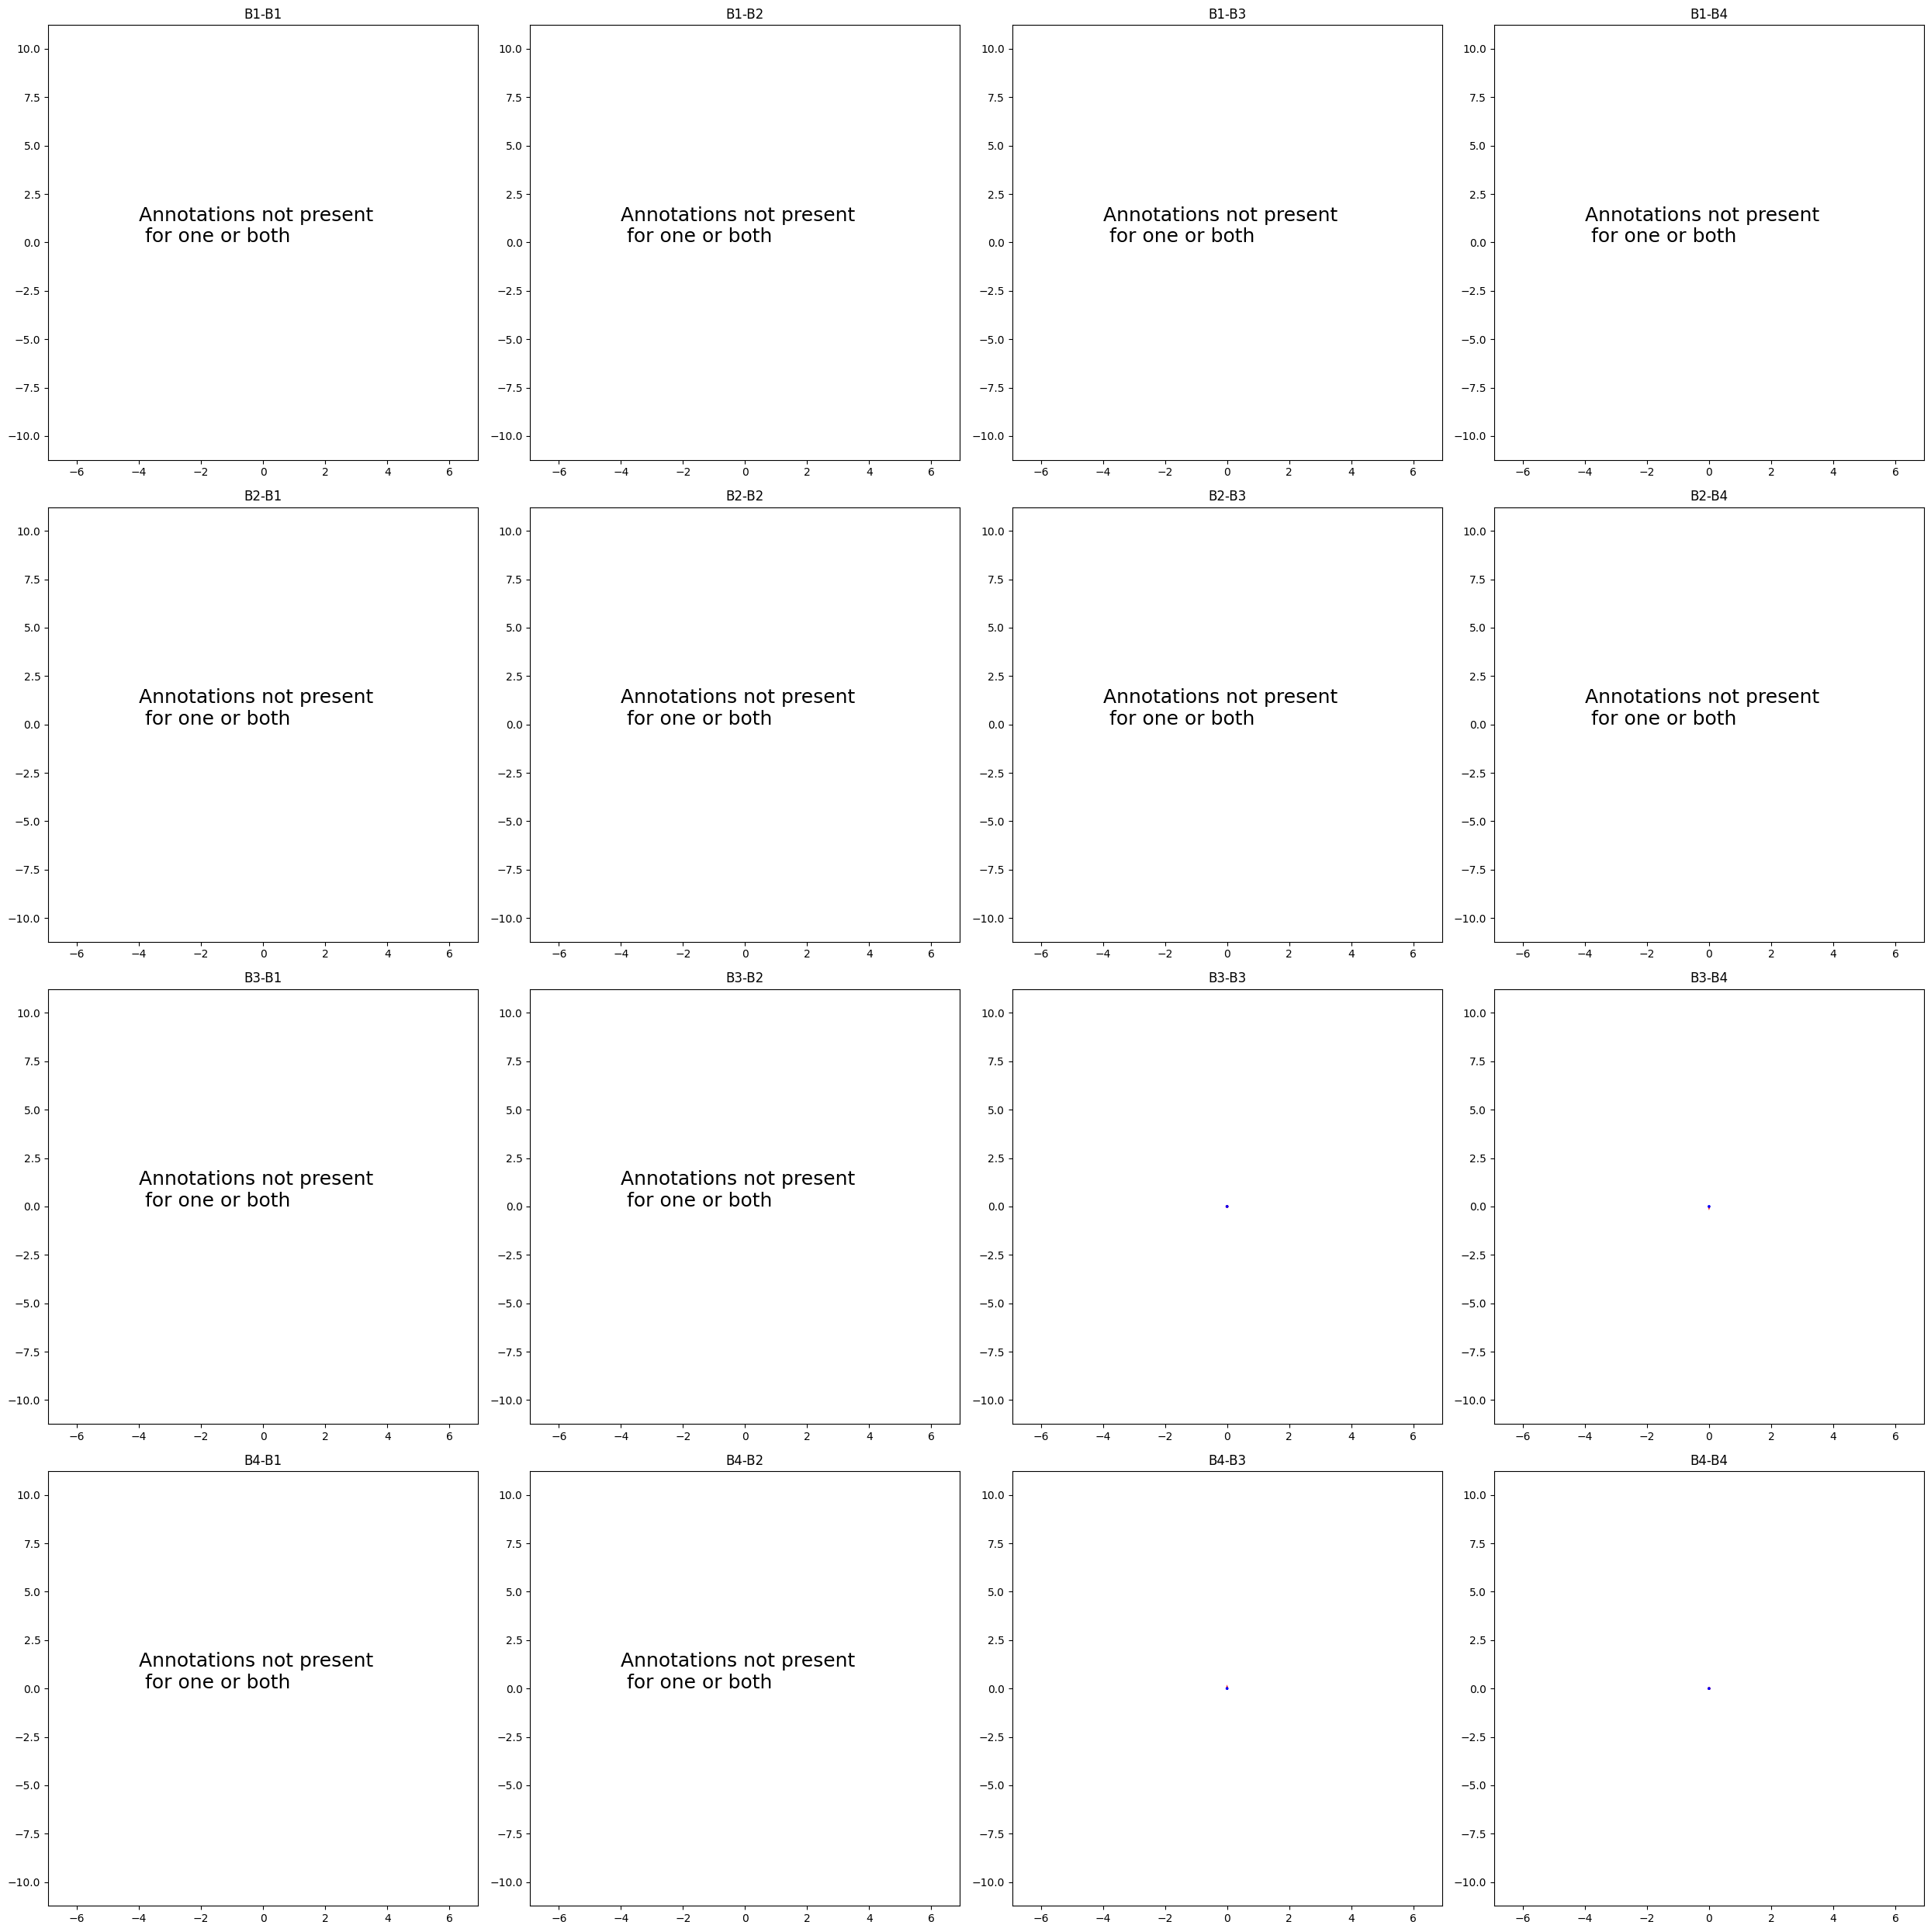

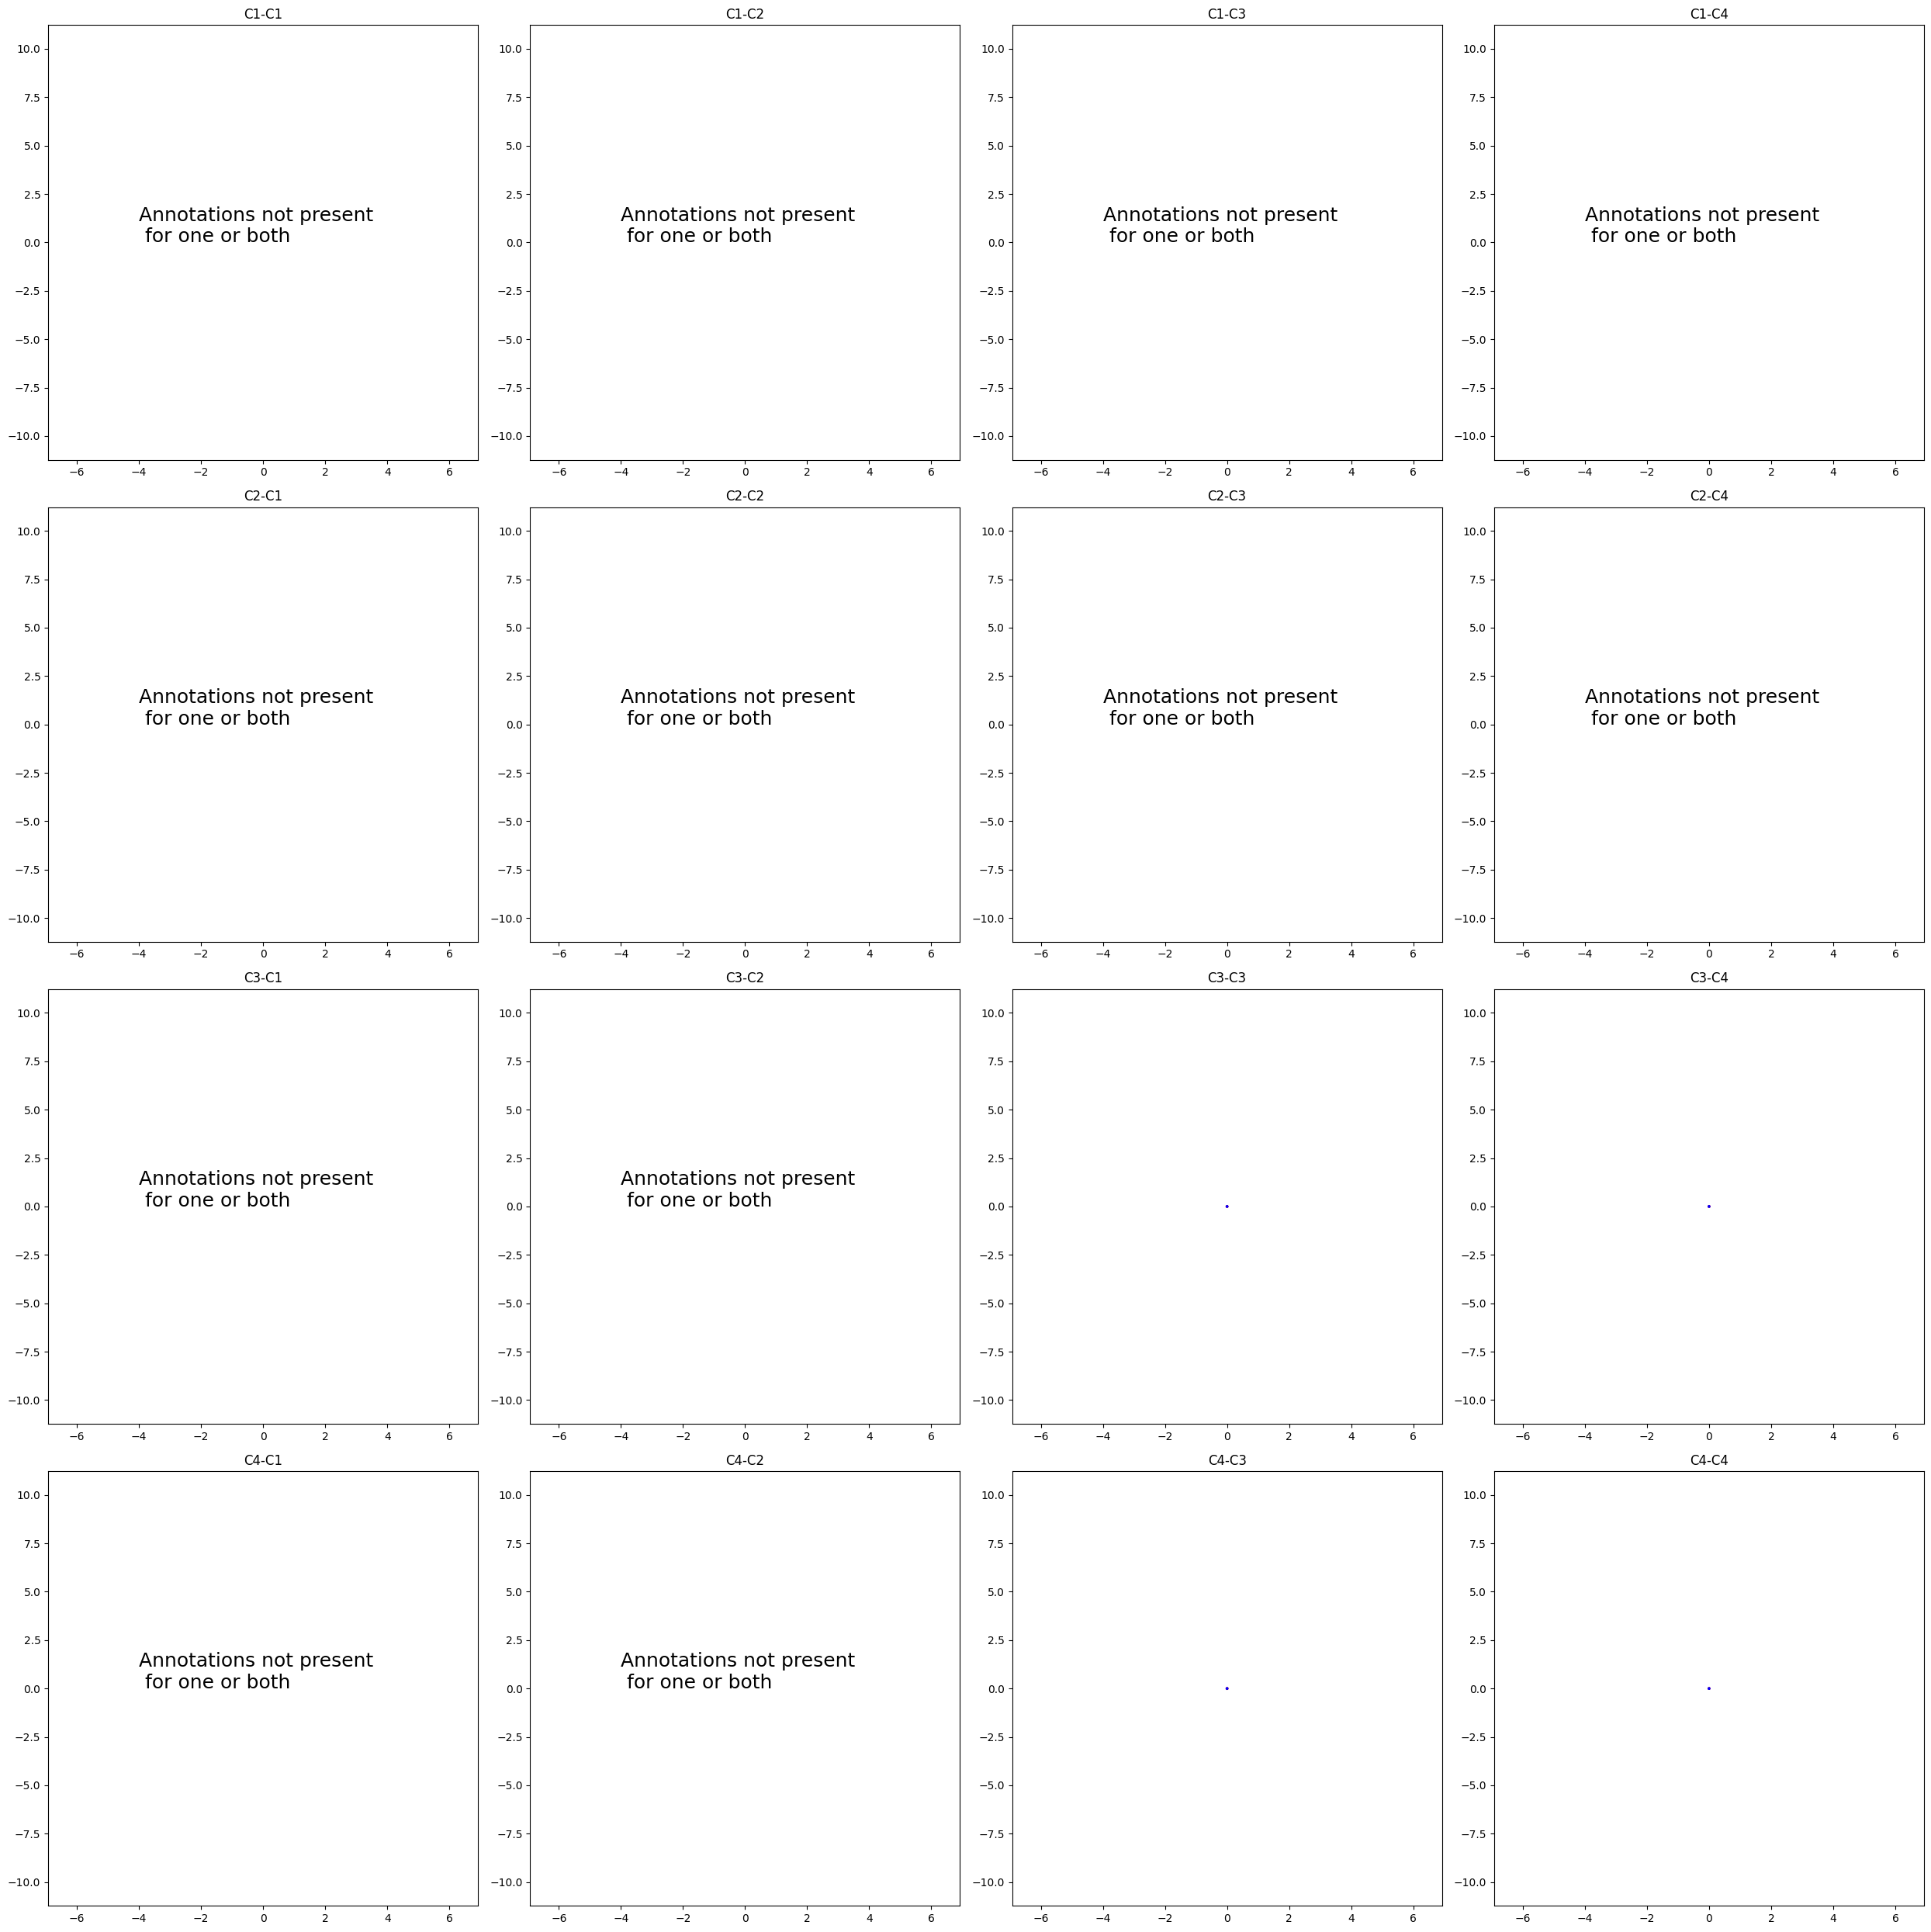

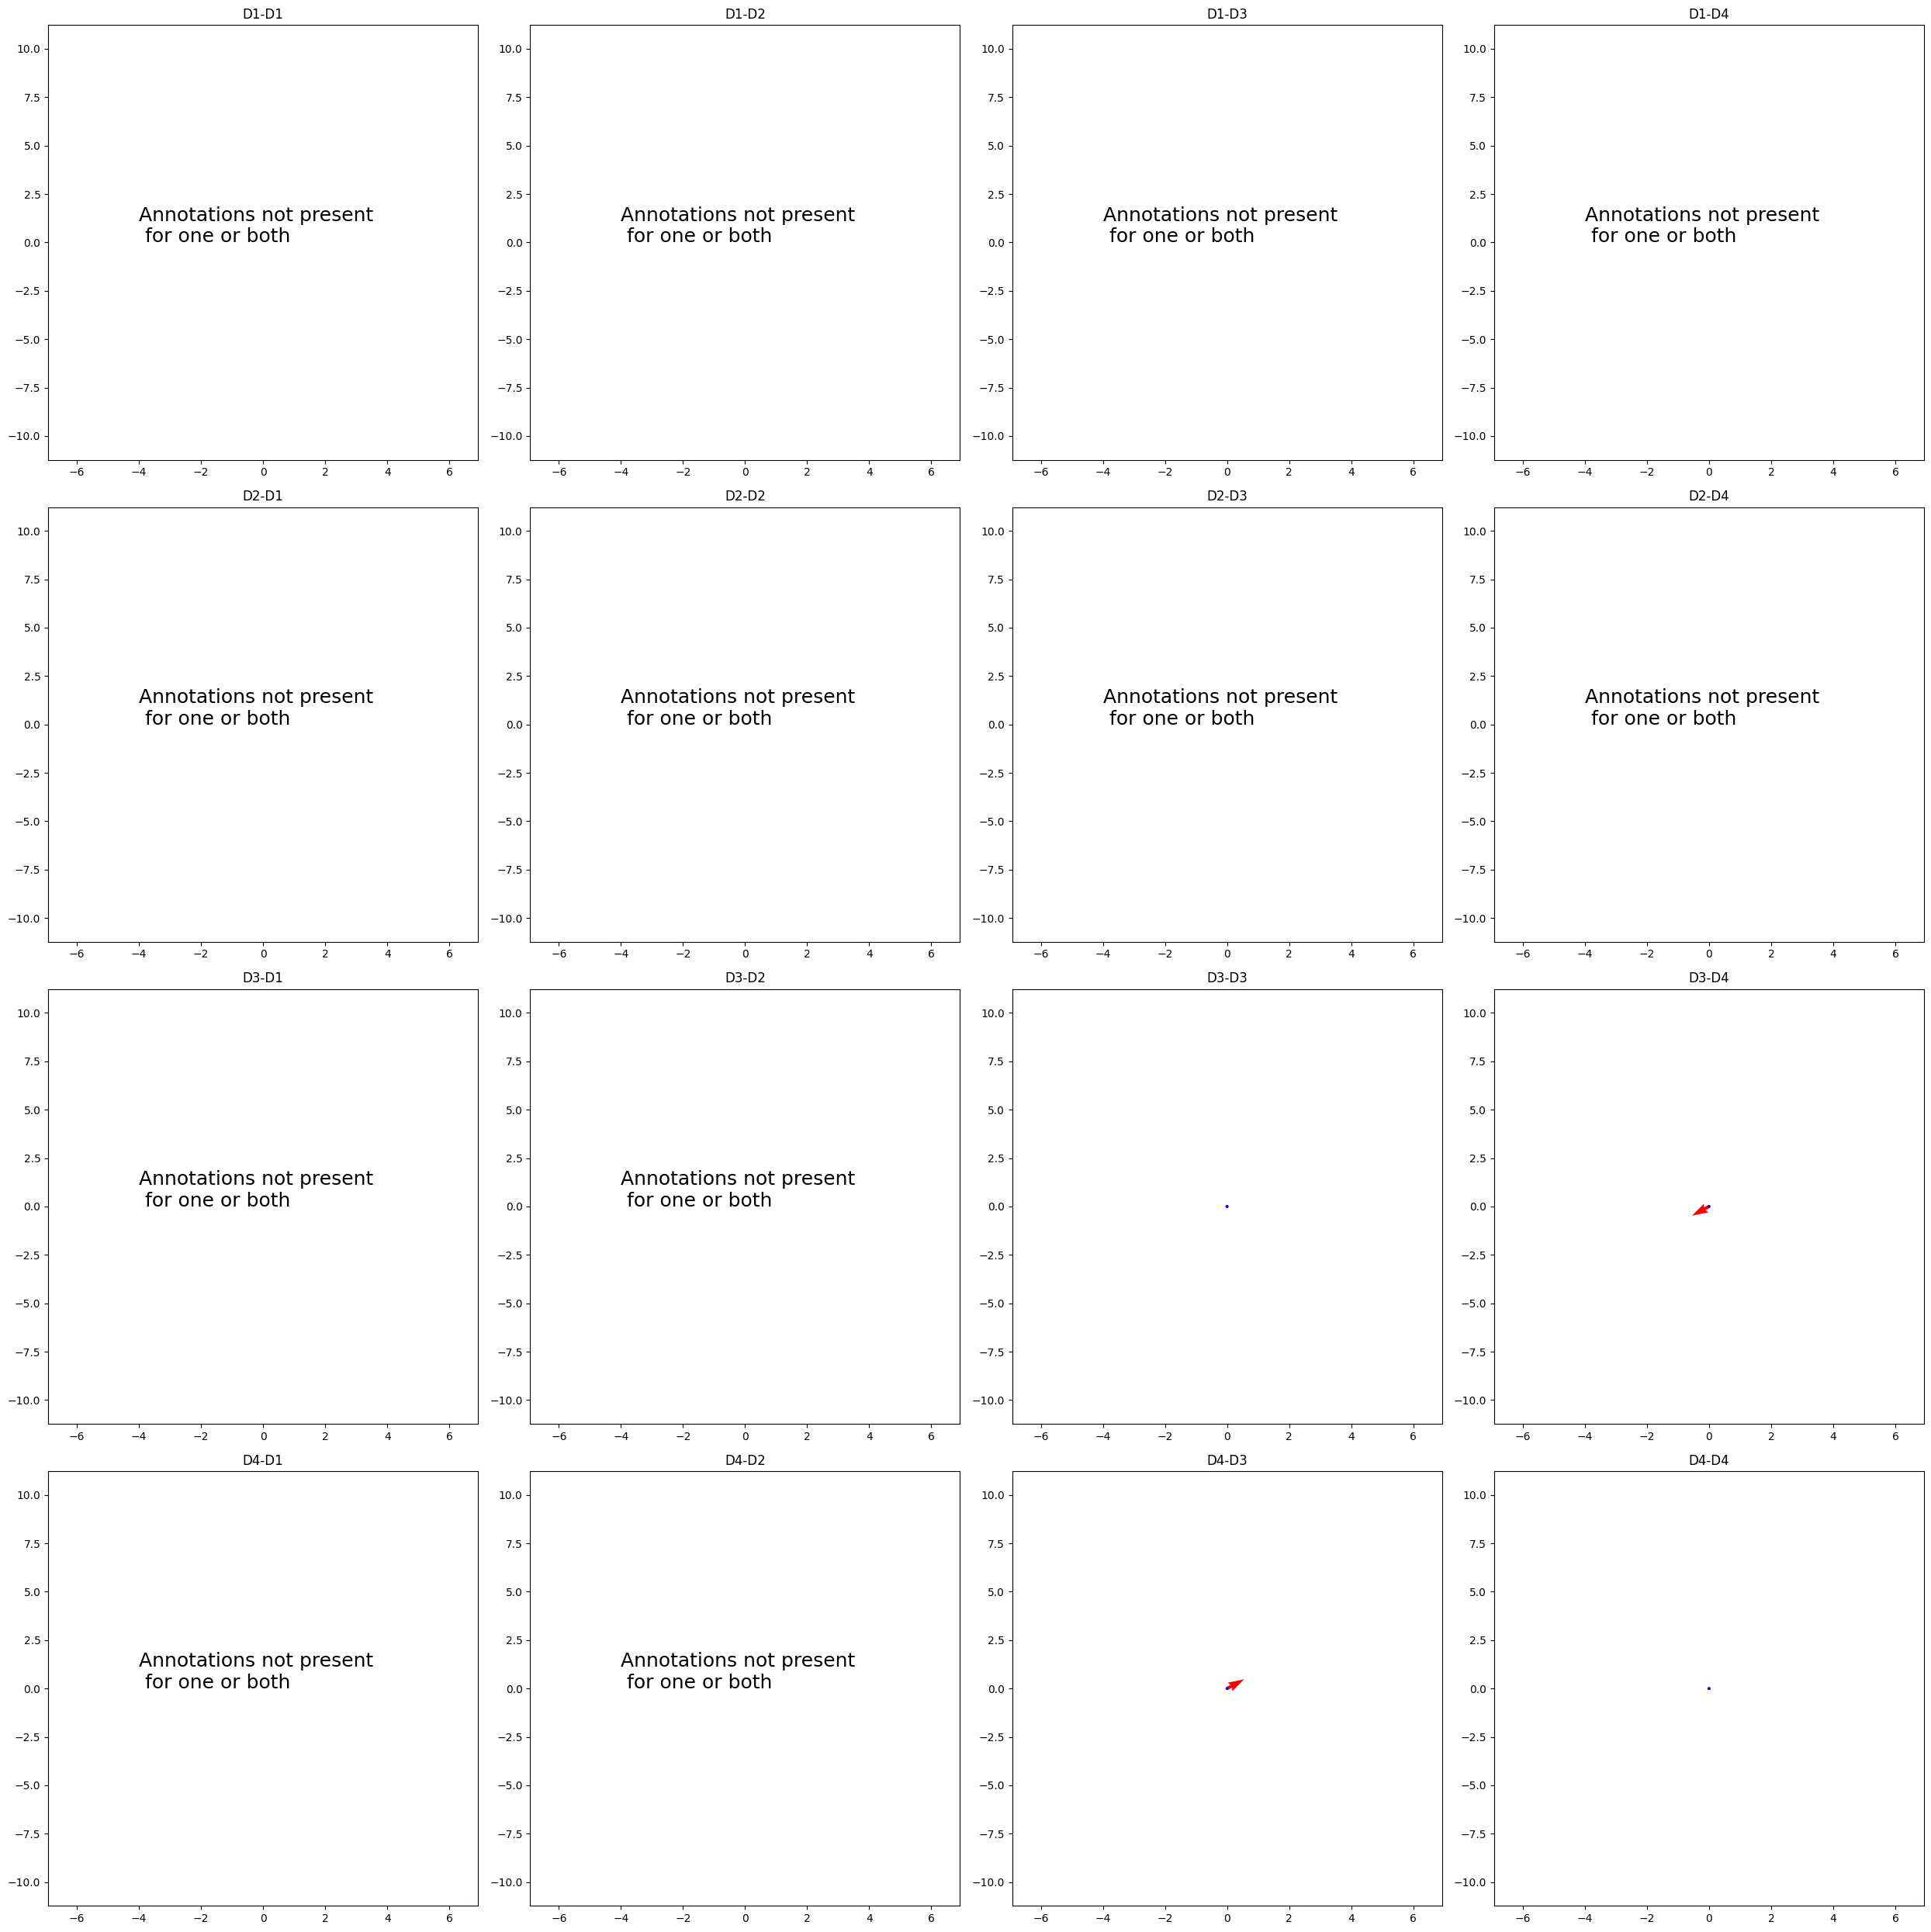

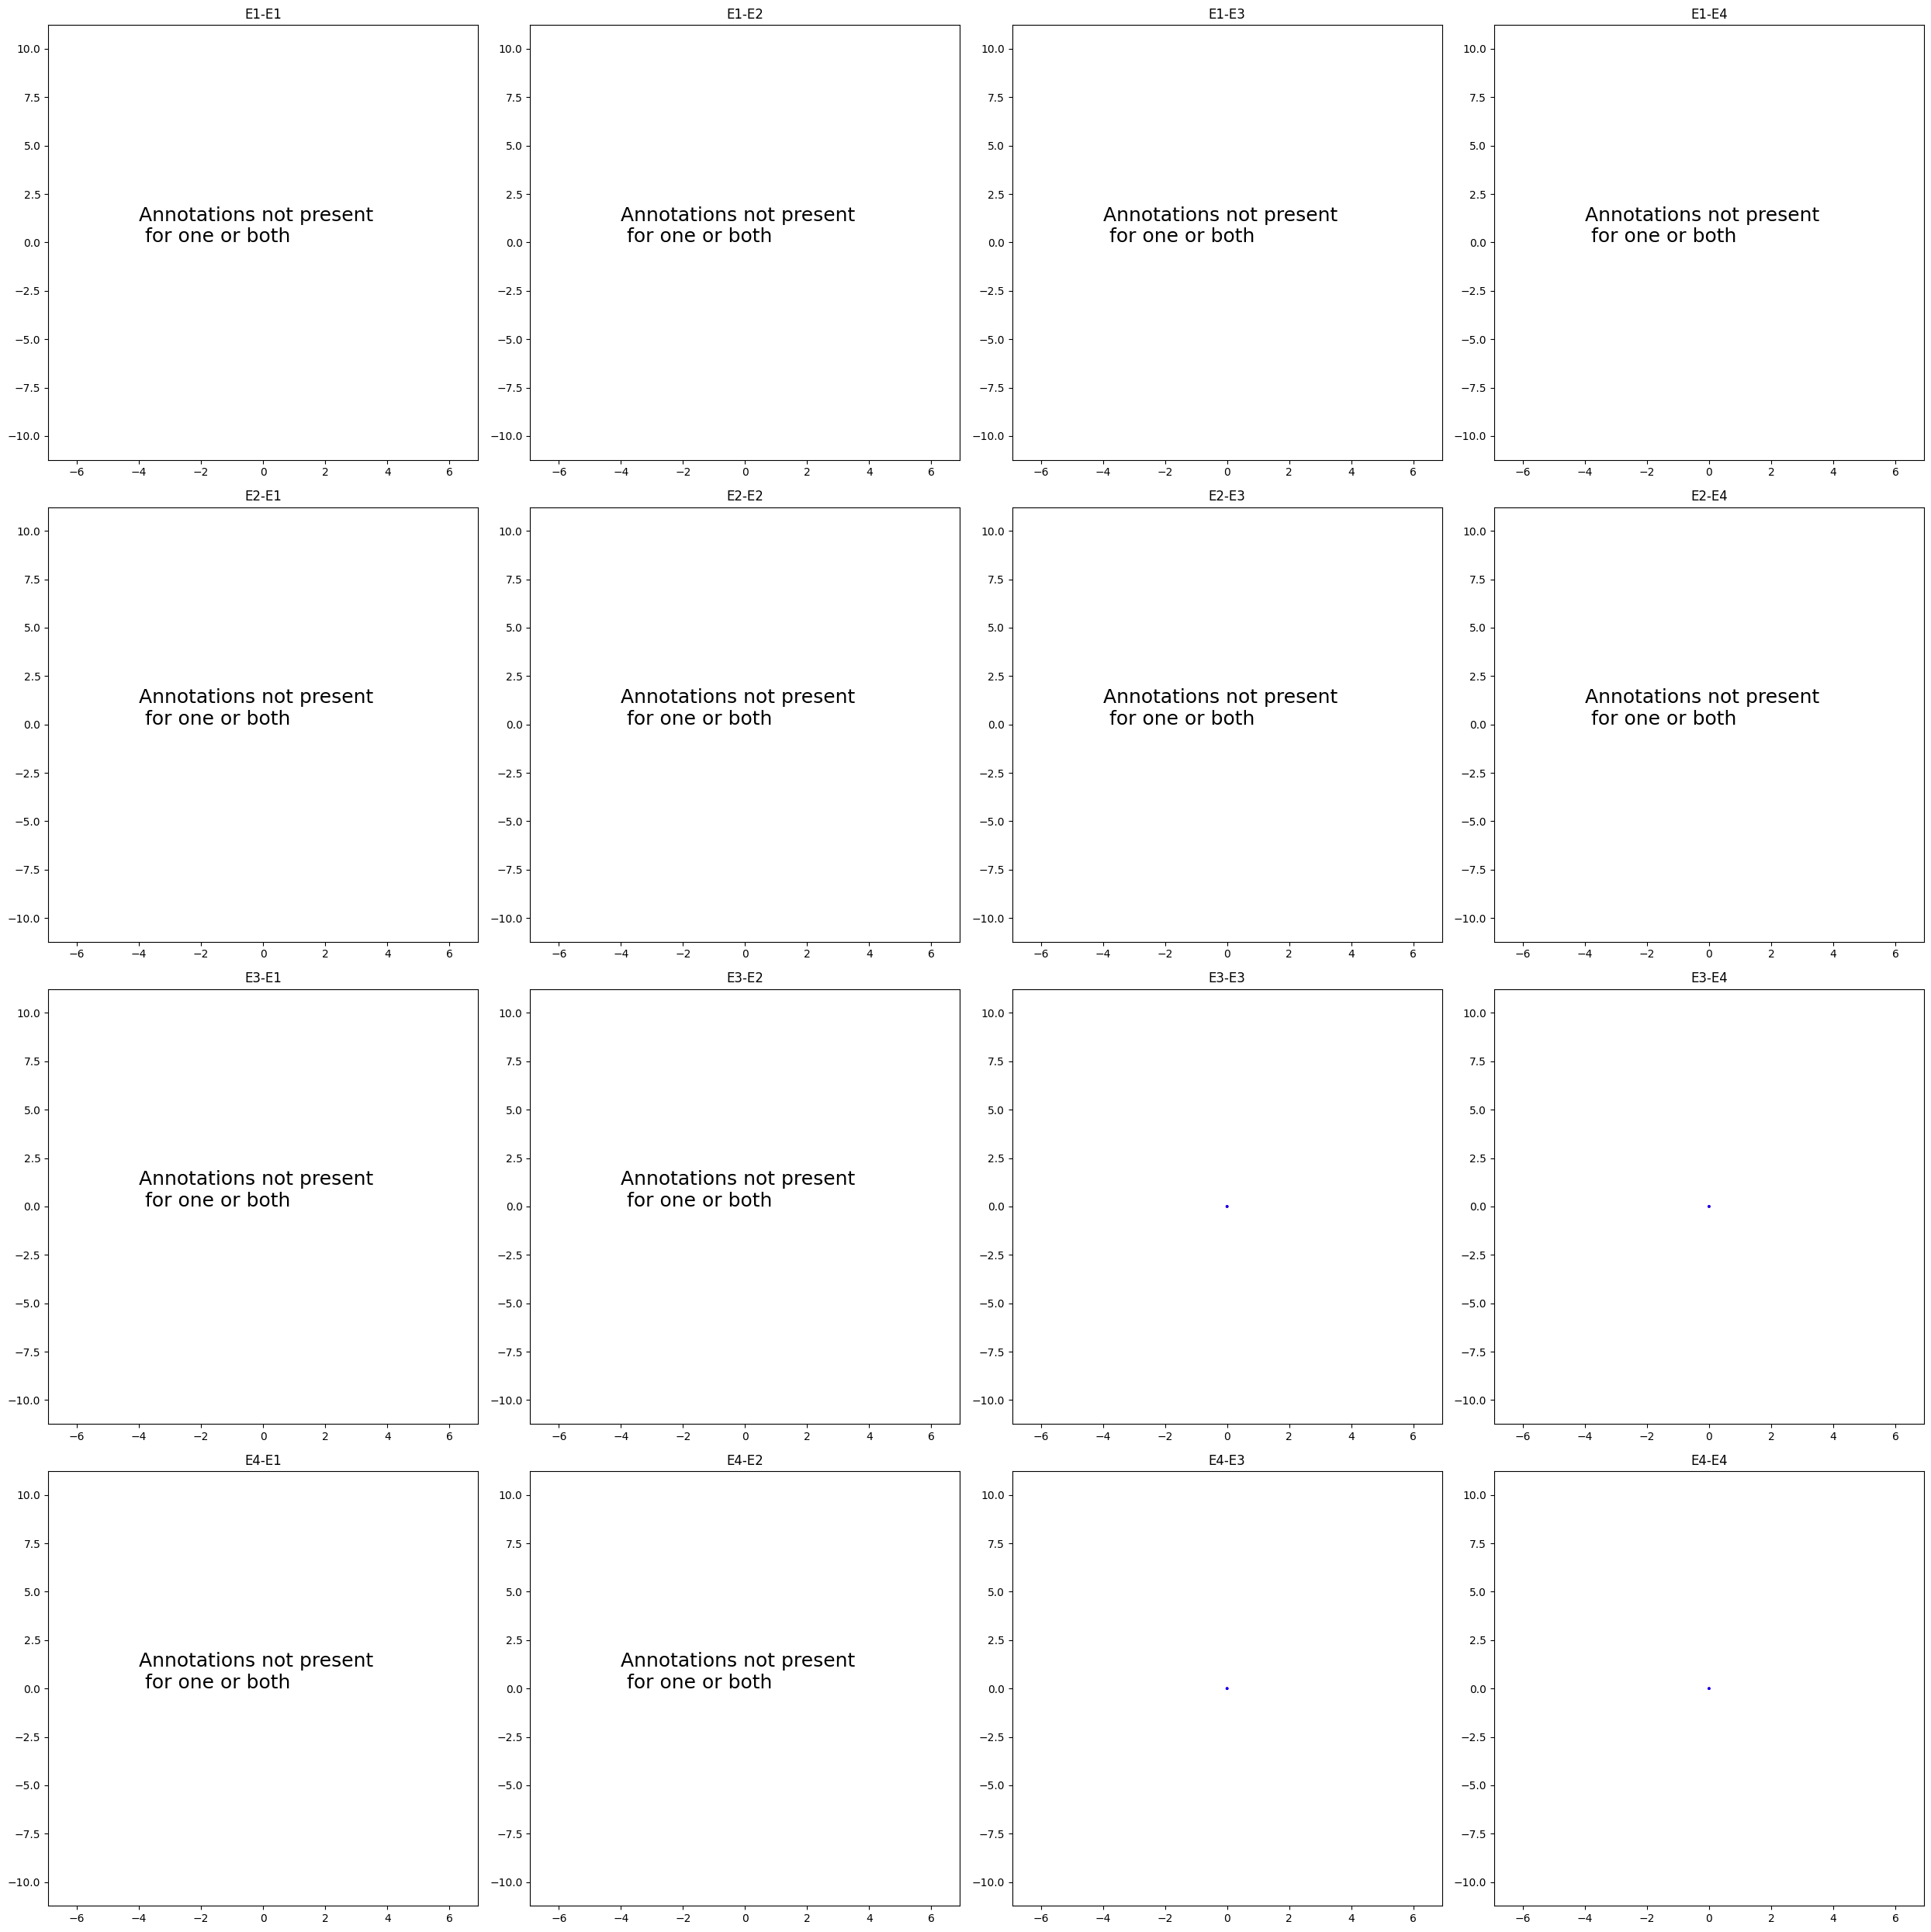

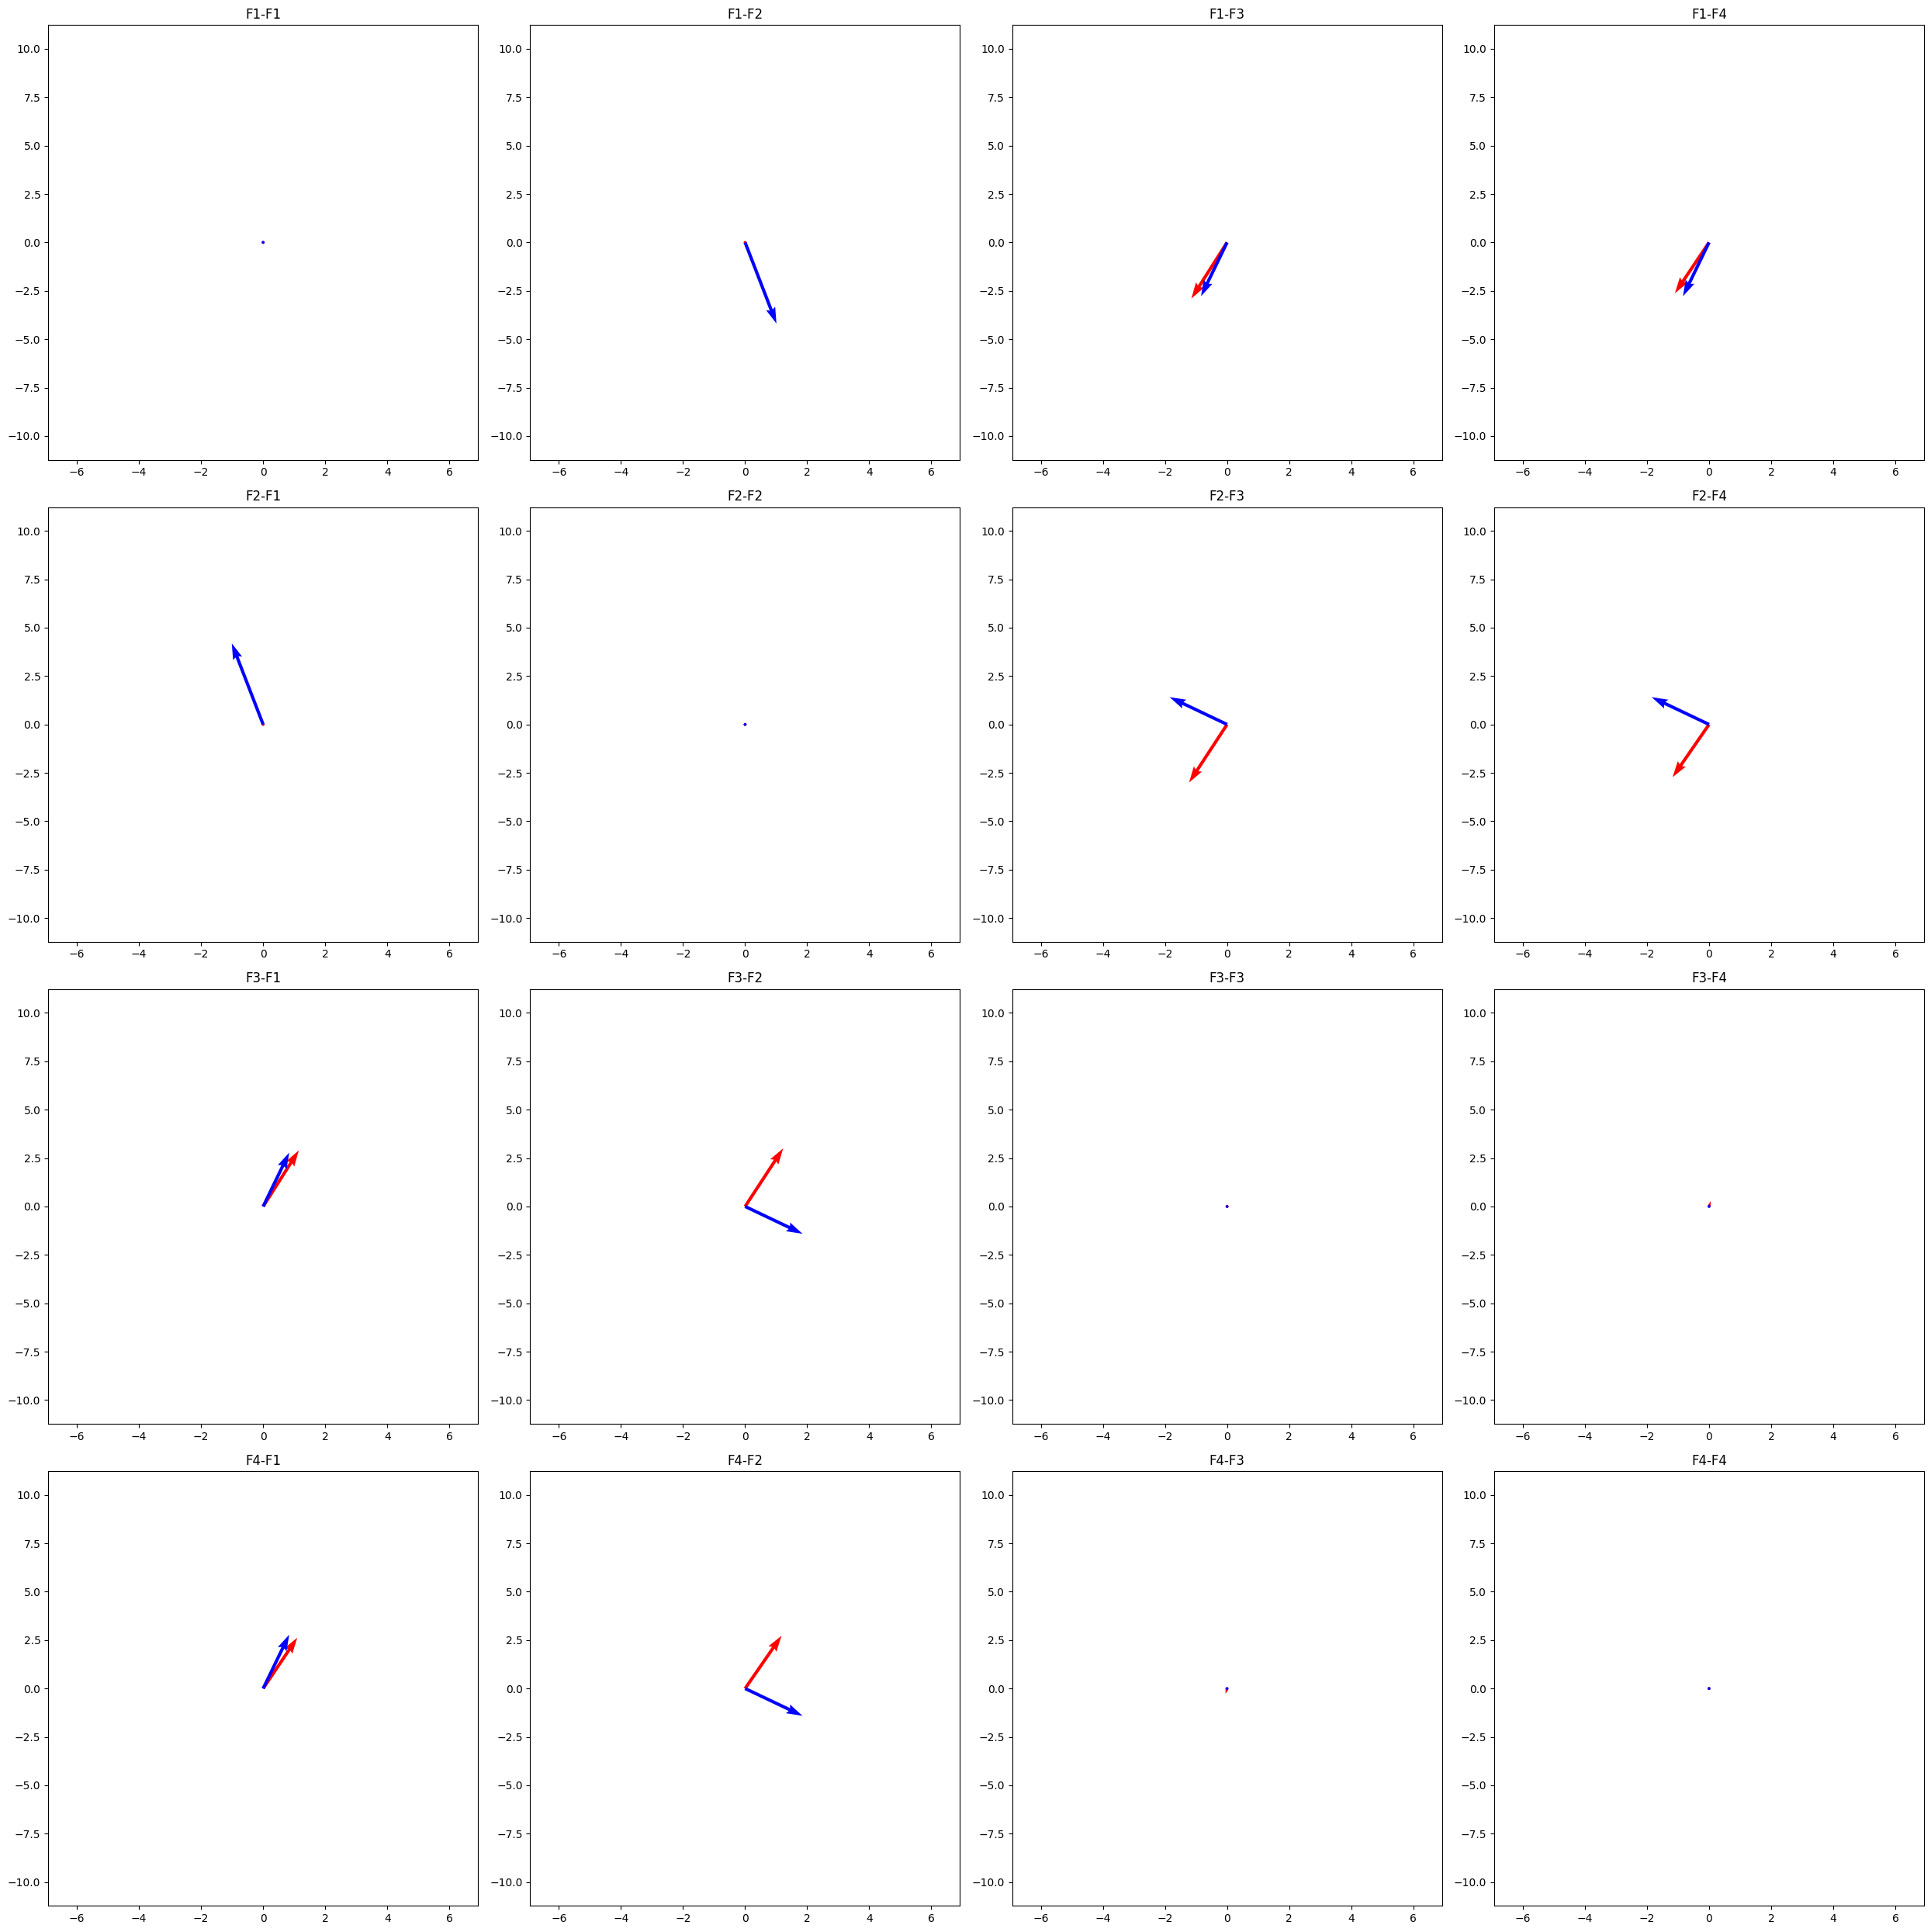

In [118]:
mid = 668755

c = get_surface_ccf_coords(mid)
cv = get_annotation_vectors(c)
h = insertion_holes_from_db(mid)
hv = get_implant_vectors(h)

plot_vectors_arjun(cv, hv, c)